# Touch Screen Data Analysis

This is my complete iPython Notebook encompassing all data analysis and machine learning that I have carried out on the touch screen data. The main objective of this analysis was to analyze the general patterns of errors generated while using touch devices. The main users of this study were **not** affected by any neurological diseases. 
This was part of my research work done under Martez Mott. 

## Setting up the environment

### Importing packages
Importing all important packages we weill need for accessing, manipulating and visualizing the data: The complete Data Exploratory Analysis

In [6]:
from sqlite3 import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

### Connecting with the SQLite Database

I have already created an SQLite Database and have imported all relevent datasets (tables) into it.
It consists of two main tables: 

#### Trials

- **id** : primary id for this table
- **trialMode** : 
    - 1: crosshair target, thumb input
    - 2: crosshair target, index finger input
    - 3: key sized target, thumb input
    - 4: key sized target, index finger input
    - 5: app sized target, thumb input
    - 6: app sized target, index finger input
    - 7: full width target, thumb input
    - 8: full width target, index finger input
- **sessionIndex**: indicates whether this trial was part of a user's first or second session - 0 (first session), 1 (second session)
- inputStyle: the hand posture in this trial - 0 (thumb input), 1 (index finger input)

- **surfaceX**: x-offset of the targeting area on the screen in pixels (can be ignored - always 0 here)
- surfaceY: y-offset of the targeting area on the screen in pixels (can be ignored - always 0 here)

- **surfaceW**: width of targeting area in pixels (always 1080 here) - this value is the horizontal resolution of the Nexus 5
- **surfaceH**: height of targeting area in pixels (always 1701 here) - this value is the vertical resolution of the Nexus 5 minus the space needed for the phone's OS softkeys and status bar

- **screenW**: width of whole screen in pixels (Nexus 5: 1080)
- **screenH**: height of whole screen in pixels (Nexus 5: 1776) - this value is the vertical resolution of the Nexus 5 minus the space needed for the phone's OS softkeys

- **subjectID**: id of the participant who performed this trial

#### Taps

- **targetX**: x coordinate of the target centre in pixels
- **targetY**: y coordinate of the target centre in pixels
- **targetW**: width of the target in pixels
- **targetH**: height of the target in pixels

- **touchDownX**: x coordinate of touch event at touch down in pixels
- **touchDownY**: y coordinate of touch event at touch down in pixels

- **touchUpX**: x coordinate of touch event at touch up in pixels
- **touchUpY**: y coordinate of touch event at touch up in pixels

- **hit**: flag indicating whether the touch up fell inside the target rectangle - 0 (miss), 1 (hit); do not interprete this value for crosshair targets (as they have no visible bounding box)

- **timeDown**: time at touch down, in milliseconds since the start of the trial
- **timeDown**: time at touch up, in milliseconds since the start of the trial

- **trialID**: id of the trial (i.e. row in table trials), to which this touch belongs

In [7]:
conn = connect("touchesDB.sqlite")
trials = pd.read_sql_query("select * from trials;", conn)
taps = pd.read_sql_query("select * from taps;", conn)

## Data cleaning and formatting

The features of our dataset are all important but we shoul get rid of the features we will not be using in our analysis. 
Our aim of this analysis is to find the minimum number of points/crosshairs and their locations on the screen which completely encompass the expected errors 

In [8]:
# drop all columns with a single value
def drop_unique(df):
    for column in df:
        if len(df[column].unique()) == 1:
            df.drop(column, axis = 1, inplace = True)

In [9]:
trials.head()
# as we can see, we can drop surfaceX surfaceY, surfaceW, surfaceH, screenW, screenH
# we can store the important dimensions as global variables

,id,trialMode,sessionIndex,inputStyle,surfaceX,surfaceY,surfaceW,surfaceH,screenW,screenH,subjectID
0,1,1,0,0,0,0,1080,1701,1080,1776,1
1,2,2,0,1,0,0,1080,1701,1080,1776,1
2,3,3,0,0,0,0,1080,1701,1080,1776,1
3,4,4,0,1,0,0,1080,1701,1080,1776,1
4,5,5,0,0,0,0,1080,1701,1080,1776,1


In [10]:
surfaceW = 1080
surfaceH = 1701
drop_unique(trials)
trials = trials[trials['trialMode'] <= 4]
trials.head()

,id,trialMode,sessionIndex,inputStyle,subjectID
0,1,1,0,0,1
1,2,2,0,1,1
2,3,3,0,0,1
3,4,4,0,1,1
8,9,2,0,1,2


In [11]:
taps.head()

,id,targetX,targetY,targetW,targetH,touchDownX,touchDownY,touchUpX,touchUpY,hit,timeDown,timeUp,trialID
0,1,906.666687,1661.000000,0,0,948,1629,948,1628,0,3321,3391,1
1,2,573.333313,242.625000,0,0,644,280,644,279,0,4996,5112,1
2,3,173.333328,715.416687,0,0,208,714,205,717,0,6137,6236,1
3,4,173.333328,1525.916626,0,0,180,1467,180,1467,0,7379,7419,1
4,5,173.333328,1323.291626,0,0,205,1495,205,1495,0,7462,7487,1


In [12]:
taps.groupby('trialID').count()['id'].unique()
# there were 400 taps for each trialID

array([400])

In [13]:
# time elapsed with finger on the screen

taps['timeTaken'] = taps['timeUp'] - taps['timeDown']
taps['touchX'] = (taps['touchDownX'] + taps['touchUpX'])/2
taps['touchY'] = (taps['touchDownY'] + taps['touchUpY'])/2
# vertical touch error
taps['touchDiffY'] = taps['touchY'] - taps['targetY']
# horizontal touch error
taps['touchDiffX'] = taps['touchX'] - taps['targetX']
# using pythogorous theorum, we can calculate the magnitude of the error vector
# given the horizontal and vertical attribute of the error vector.
taps['targetError'] = np.sqrt(np.power((taps['targetX'] - taps['touchX']),2) + \
                                np.power((taps['targetY'] - taps['touchY']),2))
drop_cols = ['timeDown', 'timeUp', 'hit', 'touchUpX', 'touchUpY', 'touchDownX', 'touchDownY']
taps.drop(drop_cols, axis = 1, inplace = True)
taps.head()

,id,targetX,targetY,targetW,targetH,trialID,timeTaken,touchX,touchY,touchDiffY,touchDiffX,targetError
0,1,906.666687,1661.000000,0,0,1,70,948.0,1628.5,-32.500000,41.333313,52.580346
1,2,573.333313,242.625000,0,0,1,116,644.0,279.5,36.875000,70.666687,79.709135
2,3,173.333328,715.416687,0,0,1,99,206.5,715.5,0.083313,33.166672,33.166776
3,4,173.333328,1525.916626,0,0,1,40,180.0,1467.0,-58.916626,6.666672,59.292608
4,5,173.333328,1323.291626,0,0,1,25,205.0,1495.0,171.708374,31.666672,174.603963


In [14]:
# join trails and taps on trialID
both = pd.merge(taps, trials, how = 'left', left_on = 'trialID', right_on='id')
both.drop(['id_x', 'id_y', 'targetW', 'targetH', 'trialID', 'sessionIndex'],axis = 1, inplace=True)
both.head()

,targetX,targetY,timeTaken,touchX,touchY,touchDiffY,touchDiffX,targetError,trialMode,inputStyle,subjectID
0,906.666687,1661.000000,70,948.0,1628.5,-32.500000,41.333313,52.580346,1.0,0.0,1.0
1,573.333313,242.625000,116,644.0,279.5,36.875000,70.666687,79.709135,1.0,0.0,1.0
2,173.333328,715.416687,99,206.5,715.5,0.083313,33.166672,33.166776,1.0,0.0,1.0
3,173.333328,1525.916626,40,180.0,1467.0,-58.916626,6.666672,59.292608,1.0,0.0,1.0
4,173.333328,1323.291626,25,205.0,1495.0,171.708374,31.666672,174.603963,1.0,0.0,1.0


## Making predictive models for each axis for the entire screen as one region 


My next step is to estimate the average error accross the entire screen by making a simple linear regression model to predict the touch X given target X and predict touchY given target Y. My thinking is that for a given model, its alpha parameter (y intercept of the line of best fit) should give me the average error of that axis across the entire screen. 

In [15]:
def reject_outliers(data, column, m):
    '''takes a dataset and column of the dataset as parameter'''
    '''removes all entries in the dataset that occur as outliers in that column of the dataset'''
    return data[abs(data[column] - np.mean(data[column])) < m * np.std(data[column])]
both_no_outliers = reject_outliers(both, 'targetError', 3.5)

[]

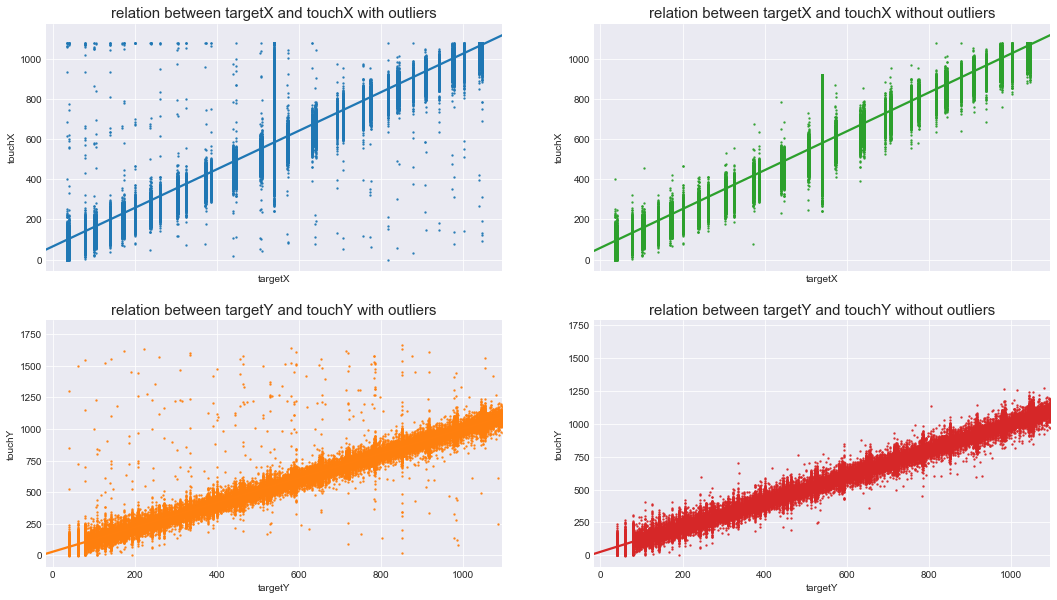

In [16]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize = (18, 10))
sns.regplot(x = both['targetX'], y = both['touchX'], ax = ax.flat[0], scatter_kws={'s':2})
ax.flat[0].set_title('relation between targetX and touchX with outliers',  fontsize = 15)
sns.regplot(x = both['targetY'], y = both['touchY'], ax = ax.flat[2], scatter_kws={'s':2})
ax.flat[2].set_title('relation between targetY and touchY with outliers',  fontsize = 15)
sns.regplot(x = both_no_outliers['targetX'], y = both_no_outliers['touchX'], ax = ax.flat[1], scatter_kws={'s':2})
ax.flat[1].set_title('relation between targetX and touchX without outliers',  fontsize = 15)
ax.flat[3].set_title('relation between targetY and touchY without outliers',  fontsize = 15)
sns.regplot(x = both_no_outliers['targetY'], y = both_no_outliers['touchY'], ax = ax.flat[3], scatter_kws={'s':2})
plt.plot()

In [17]:
regrx = linear_model.LinearRegression()
x1 = both_no_outliers['targetX']
y1 = both_no_outliers['touchX']
regrx.fit(x1.values.reshape(-1, 1), y1.values.reshape(-1, 1))
interceptx = regrx.intercept_[0]
print("The average x direction error of all taps is: " + str(interceptx))
# if our coeficient is 1 then : 
# Here, an intercept of 60.65 can be interpreted as : "At an average, the X attribute of the error
# is +60.65 
regry = linear_model.LinearRegression()
x2 = both_no_outliers['targetY']
y2 = both_no_outliers['touchY']
regry.fit(x2.values.reshape(-1, 1), y2.values.reshape(-1, 1))
intercepty = regry.intercept_[0]
print("The average y direction error of all taps is: " + str(intercepty))
# if our coeficient is 1 then : 
# Here, an intercept of 26.8 can be interpreted as : "At an average, the Y attribute of the error
# is +26.80 
# It is important to keep in mind that the Y axis in our mental model has been inverted
# Therefore (0,0) is at the top-left corner of the graph of x vs y

The average x direction error of all taps is: 58.519905589718405
The average y direction error of all taps is: 26.718446730409028


In [18]:
# Lets varify this by simply averaging out the X direction error values
print("The average x direction error of all taps is: " + str(np.mean(both_no_outliers['touchDiffX'])))
# and similarly for the Y direction errors
print("The average x direction error of all taps is: " + str(np.mean(both_no_outliers['touchDiffY'])))
# This does not add up!

The average x direction error of all taps is: 40.99537622904895
The average x direction error of all taps is: 4.966199203767729


In [19]:
# But our coefficient is not 1, it is 0.97
# so lets try and convert our average to the intercept value: 
betax = regrx.coef_[0]
betay = regry.coef_[0]
print("The corrected average x direction error of all taps is: " + \
      str(np.mean(both_no_outliers['touchDiffX']) + (1 - betax)*np.mean(x1)))
print("The corrected average x direction error of all taps is: " + \
      str(np.mean(both_no_outliers['touchDiffY']) + (1 - betay)*np.mean(x2)))
# makes sense now
print("coefficient for x error: " + str(betax))
print("coefficient for y error: " + str(betay))

The corrected average x direction error of all taps is: [58.51990559]
The corrected average x direction error of all taps is: [26.71844673]
coefficient for x error: [0.96755786]
coefficient for y error: [0.97449658]


In [20]:
# Lets have a look at our data set again
both_no_outliers.head()

,targetX,targetY,timeTaken,touchX,touchY,touchDiffY,touchDiffX,targetError,trialMode,inputStyle,subjectID
0,906.666687,1661.000000,70,948.0,1628.5,-32.500000,41.333313,52.580346,1.0,0.0,1.0
1,573.333313,242.625000,116,644.0,279.5,36.875000,70.666687,79.709135,1.0,0.0,1.0
2,173.333328,715.416687,99,206.5,715.5,0.083313,33.166672,33.166776,1.0,0.0,1.0
3,173.333328,1525.916626,40,180.0,1467.0,-58.916626,6.666672,59.292608,1.0,0.0,1.0
4,173.333328,1323.291626,25,205.0,1495.0,171.708374,31.666672,174.603963,1.0,0.0,1.0


## Making predictive models on different regions of the screen

Our approach to this would be first visualizing how error fluxtuates accross each of the axis in different areas of the screen. 

In [21]:
# we can split our dataset into taps made with finger and thumb
points = both_no_outliers[['touchX', 'touchY', 'targetX', 'targetY', 'inputStyle']]
finger_taps = points[points['inputStyle'] == 1]
finger_taps.drop('inputStyle', axis = 1, inplace = True)
thumb_taps = points[points['inputStyle'] == 0]
thumb_taps.drop('inputStyle', axis = 1, inplace = True)

In [22]:
# only interested in the fingers dataset currently
# going to make model on the fingers dataset but can also be used for the thumbs dataset
# as the tables are identical in schemas. 
fingers = finger_taps.copy()

finger_taps['errorX'] = finger_taps['targetX'] - finger_taps['touchX']
finger_taps['errorY'] = finger_taps['targetY'] - finger_taps['touchY']
finger_taps.head()

,touchX,touchY,targetX,targetY,errorX,errorY
400,674.0,1473.0,640.000000,1458.375000,-34.000000,-14.625000
401,734.5,43.0,706.666687,40.000000,-27.833313,-3.000000
402,744.0,603.0,706.666687,580.333313,-37.333313,-22.666687
403,194.5,1684.5,173.333328,1661.000000,-21.166672,-23.500000
404,382.0,1490.0,373.333344,1458.375000,-8.666656,-31.625000


In [23]:
def make_group(df, bucket_size = 10):
    df['groupX'] = np.floor(df['targetX']/bucket_size)
    df['groupY'] = np.floor(df['targetY']/bucket_size)

In [24]:
make_group(finger_taps)
finger_taps.head()

,touchX,touchY,targetX,targetY,errorX,errorY,groupX,groupY
400,674.0,1473.0,640.000000,1458.375000,-34.000000,-14.625000,64.0,145.0
401,734.5,43.0,706.666687,40.000000,-27.833313,-3.000000,70.0,4.0
402,744.0,603.0,706.666687,580.333313,-37.333313,-22.666687,70.0,58.0
403,194.5,1684.5,173.333328,1661.000000,-21.166672,-23.500000,17.0,166.0
404,382.0,1490.0,373.333344,1458.375000,-8.666656,-31.625000,37.0,145.0


In [25]:
def make_screen_region_data(surfaceDimension, df, partitions, axis):
    col = ''
    if(axis == 'X'):
        col = 'targetY'
    else:
        col = 'targetX'
    all_regions = []
    for i in range(partitions):
        partitions = 1.0*partitions
        part_df = df[(df[col] > i*surfaceDimension/partitions) & \
                    (df[col] <= (i+1)*surfaceDimension/partitions)]
        all_regions.append(part_df)
    return all_regions

In [26]:
def get_mean_error(df, axis):
    return pd.DataFrame(df.groupby('group' + axis).mean()['error' + axis])

In [27]:
def plot_variation_against_axis(axis, partitions):
    surfaceD = 0
    if(axis == 'X'):
        surfaceD = surfaceH
    else:
        surfaceD = surfaceW
    all_regions = make_screen_region_data(surfaceD, finger_taps, partitions, axis)
    titles = [
        'Upper Screen Error Across ' + axis + ' axis',
        'Upper Middle Screen Error Across ' + axis + ' axis', 
        'Middle Screen Error Across ' + axis + ' axis',
        'Lower Middle Screen Error Across ' + axis + ' axis',
        'Lower Screen Error Across ' + axis + ' axis'
    ]
    plots = []
    plt.figure(figsize=(10,10))  
    for i in range(len(all_regions)):
        error_df = get_mean_error(all_regions[i], axis)
        plot, = plt.plot(error_df.index*10, error_df['error' + axis], alpha = 0.5, label = titles[i])
        plots.append(plot)
    plt.legend(handles = plots)  

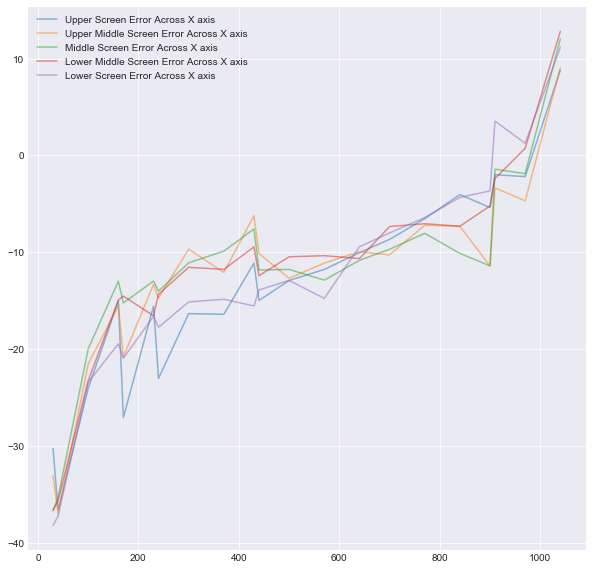

In [28]:
plot_variation_against_axis('X', 5)
# as we see below, there is almost an identical function of the error accross x axis 
# regardless of the section of the screen

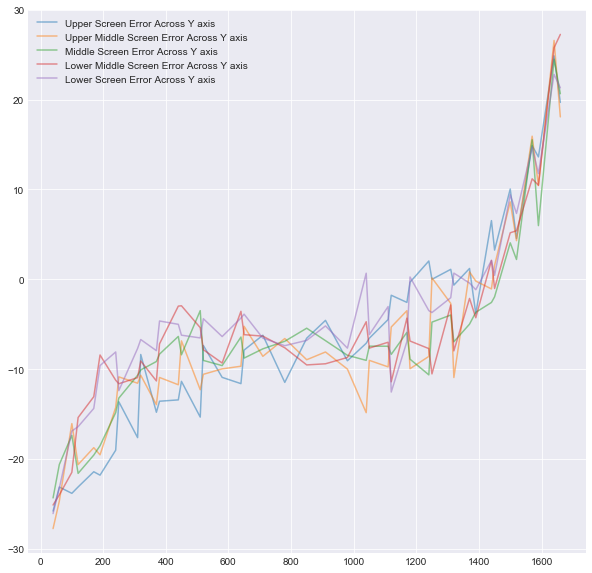

In [29]:
plot_variation_against_axis('Y', 5)
# as we see below, there is almost an identical function of the error accross y axis 
# regardless of the section of the screen

In [30]:
def plot(touchData, color = False, w=surfaceW, h=surfaceH):
    """
    Creates a scatter plot of the given target locations.
    Targets are connected to their corresponding touches by lines.
    """
    n = len(touchData)
    plt.figure(figsize = (7,10))
    #plt.subplot(111)
    plt.xlim((0, w))
    plt.ylim((h,0))
    for i in range(n):
        if(color):
            cmap = plt.get_cmap('spectral')
            colors = [cmap(i) for i in np.linspace(0, 1, len(touchData['cluster'].unique()))]
            plt.scatter(touchData.iloc[i, 0], touchData.iloc[i, 1], color = colors[touchData.iloc[i, -1]], s=15)
        else:
            xVals = (touchData.iloc[i, 0], touchData.iloc[i, 2])
            yVals = (touchData.iloc[i, 1], touchData.iloc[i, 3])  
            plt.plot(xVals, yVals, color='k', lw=1)
            plt.scatter(touchData.iloc[i, 0], touchData.iloc[i, 1], color='k', s=15)
    
    plt.tight_layout()
    plt.show()

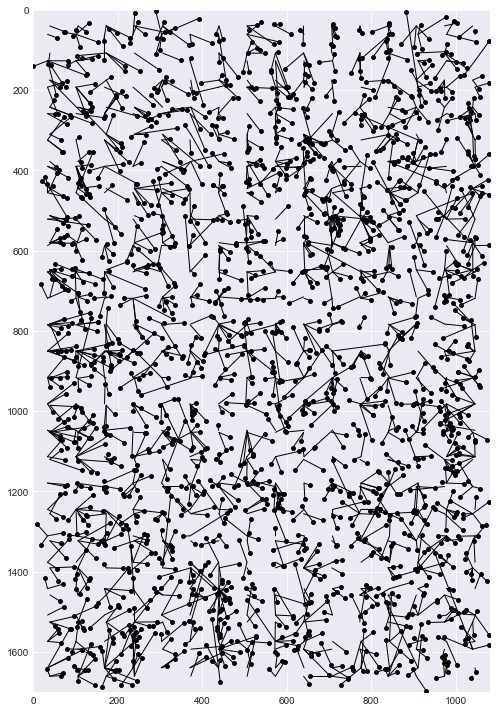

In [31]:
plot(finger_taps.sample(2000))

## K-Nearest-Neighbors for predicting error value and direction

In order to find the areas of the screen with similar error values and direction, we need to first average out the errors across all points of the screen for each point of the screen.

The best way to do so is the use the nearest neighbors (preferably a high number of neighbors to get a smooth function) and take the weighted mean of their error values to predict the error value for a point on the screen. 
I say "wieghted mean" as it makes intuitive sense to weigh the closer numbers higher and farther neighbors lower. 

In [32]:
from sklearn.neighbors import KNeighborsRegressor
regrX = KNeighborsRegressor(n_neighbors = 500, weights = 'distance')
regrY = KNeighborsRegressor(n_neighbors = 500, weights = 'distance')
pred = {}
targets = finger_taps[['targetX', 'targetY']]
regrX.fit(targets, finger_taps['touchX'])
regrY.fit(targets, finger_taps['touchY'])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=500, p=2,
          weights='distance')

In [33]:
dicts = []
for i in range(50, (int)(np.max(finger_taps['targetX'])), 25):
    for j in range(50, (int)(np.max(finger_taps['targetY'])), 25):
        pred = {}
        pred['targetX'] = i
        pred['targetY'] = j
        pred['touchX'] = regrX.predict(np.array([i, j]).reshape(1, -1))[0]
        pred['touchY'] = regrY.predict(np.array([i, j]).reshape(1, -1))[0]
        dicts.append(pred)

In [34]:
predFrame = pd.DataFrame(dicts)
predFrame.head()

,targetX,targetY,touchX,touchY
0,50,50,96.136739,88.145406
1,50,75,91.165079,110.339481
2,50,100,88.332430,126.297370
3,50,125,87.848706,147.066914
4,50,150,89.115450,169.116852


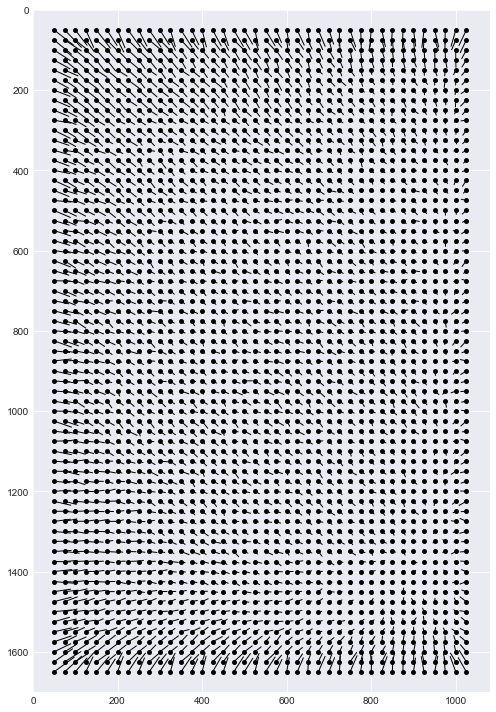

In [35]:
plot(predFrame)
# This is the plot we get of the average error values and direction for each point on the phone screen. 

## K-means to find the clusters of points with similar error values and directions

We can try to find the groups of points with similar error value and direction, but the problem with this approach is that we need to specify the number of clusters in the system. But instead the whole point of this study is to solve for an optimal number of clusters. 

One solution for this could be graphing out the heterogeniety values for different values of k, and then choosing k such that the change in heterogeneity w.r.t k is comparatively small. You can think of this as the inflection point on the graph, but chossing a slighly higher value of k than the one on the inflection point. 

In [36]:
predFrame['errorX1'] = predFrame['targetX'] - predFrame['touchX']
predFrame['errorY1'] = predFrame['targetY'] - predFrame['touchY']
predFrame.drop(['touchX', 'touchY'], axis = 1, inplace = True)
predFrame.head()

,targetX,targetY,errorX1,errorY1
0,50,50,-46.136739,-38.145406
1,50,75,-41.165079,-35.339481
2,50,100,-38.332430,-26.297370
3,50,125,-37.848706,-22.066914
4,50,150,-39.115450,-19.116852


In [37]:
from sklearn.cluster import KMeans
def cluster_points(data, k, verbose = True):
    # normalize every column
    dataNorm = data.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x))) 
    cls = KMeans(init = 'k-means++', n_clusters = k).fit(dataNorm)
    clusters = cls.predict(dataNorm)
    data['cluster'] = clusters
    if(verbose):
        plot(data, color= True)
    return pd.DataFrame(cls.cluster_centers_), data

In [38]:
def calculate_heterogeneity(data, centroids):
    tot = 0
    for cluster in data['cluster'].unique():
        tot += l2dist(centroids.iloc[cluster, :], data[data['cluster'] == cluster].drop('cluster', axis = 1))
    return tot

def l2dist(arr, df):
    tot = 0
    for index, row in df.iterrows():
        row = np.array(row)
        arr = np.array(arr)
        tot += (np.square(arr - row)).sum()
    return tot

In [39]:
def show_various_k_het(k_range, data): 
    h = []
    dataog = data.copy()
    for k in range(1, k_range + 1):
        data = dataog.copy()
        centroids, update = cluster_points(data, k, verbose = False)
        h.append(calculate_heterogeneity(update, centroids))
    data = dataog.copy()
    plt.plot(range(1, k_range + 1), h)

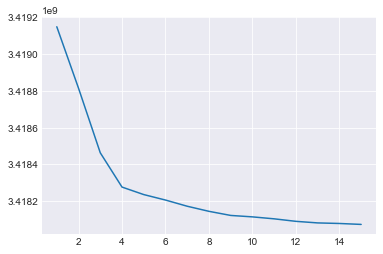

In [40]:
show_various_k_het(15, predFrame)
# seems like k = (8,9,10) fit our description of the optimal number of clusters well. Lets plot out the
# clusters for the different values of the optimal ks. 

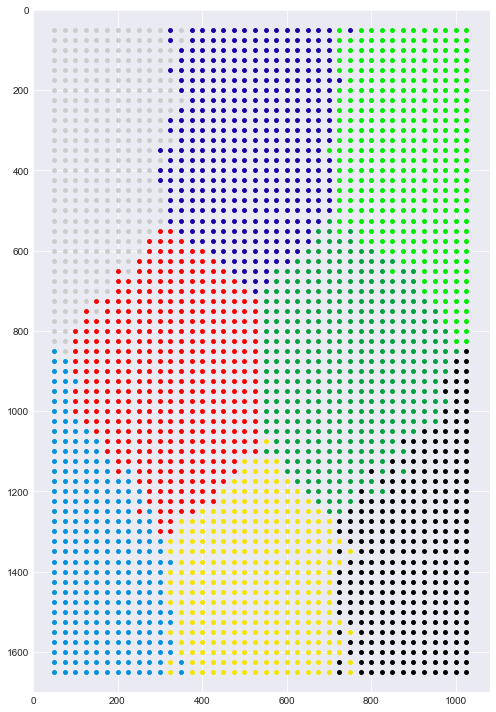

In [41]:
_,_ = cluster_points(predFrame, 8)

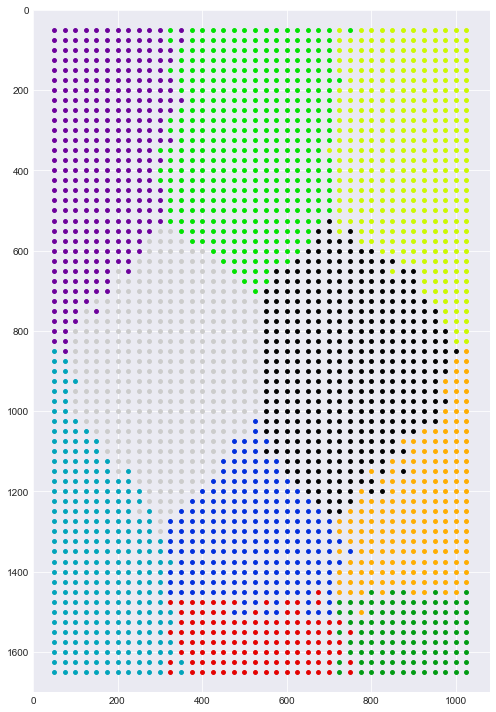

In [42]:
_, _ = cluster_points(predFrame, 10)

## Taking into consideration just one axis while prediction the error for that axis

Lets try and my a KNN model which predicts the x-direction error given our target value of x. 
Similarly the same for y axis. 

In [43]:
regrXSingle = KNeighborsRegressor(n_neighbors = 500, weights = 'distance')
regrYSingle = KNeighborsRegressor(n_neighbors = 500, weights = 'distance')
regrXSingle.fit(finger_taps[['targetX']], finger_taps['touchX'])
regrYSingle.fit(finger_taps[['targetY']], finger_taps['touchY'])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=500, p=2,
          weights='distance')

In [44]:
dicts = []
for i in range(50, (int)(np.max(finger_taps['targetX'])), 25):
    for j in range(50, (int)(np.max(finger_taps['targetY'])), 25):
        pred = {}
        pred['targetX'] = i
        pred['targetY'] = j
        pred['touchX'] = regrXSingle.predict(np.array([i]).reshape(1, -1))[0]
        pred['touchY'] = regrYSingle.predict(np.array([j]).reshape(1, -1))[0]
        dicts.append(pred)
singleAxisPred = pd.DataFrame(dicts)
singleAxisPred.head()

,targetX,targetY,touchX,touchY
0,50,50,75.536,66.260
1,50,75,75.536,81.142
2,50,100,75.536,124.623
3,50,125,75.536,148.170
4,50,150,75.536,148.704


In [45]:
singleAxisPred['errorX'] = singleAxisPred['targetX'] - singleAxisPred['touchX']
singleAxisPred['errorY'] = singleAxisPred['targetY'] - singleAxisPred['touchY']

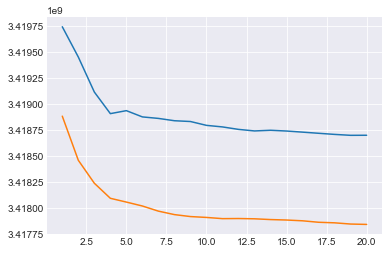

In [46]:
singleAxisPred.drop(['touchX', 'touchY'], axis = 1, inplace = True)
XPred = singleAxisPred.drop('errorY', axis = 1)
YPred = singleAxisPred.drop('errorX', axis = 1)
show_various_k_het(20, XPred)
show_various_k_het(20, YPred)

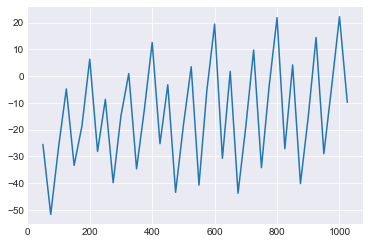

In [47]:
plt.plot(XPred.targetX, XPred.errorX)

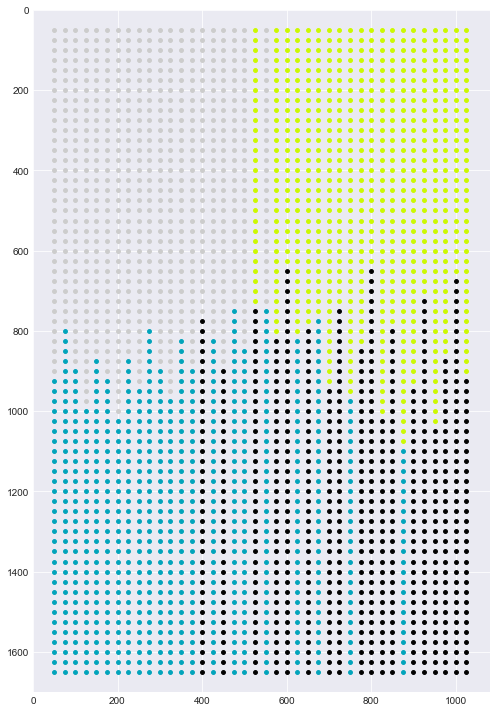

In [48]:
_, _ = cluster_points(XPred, 4)
# This approach did not work as well as the previous approach. 

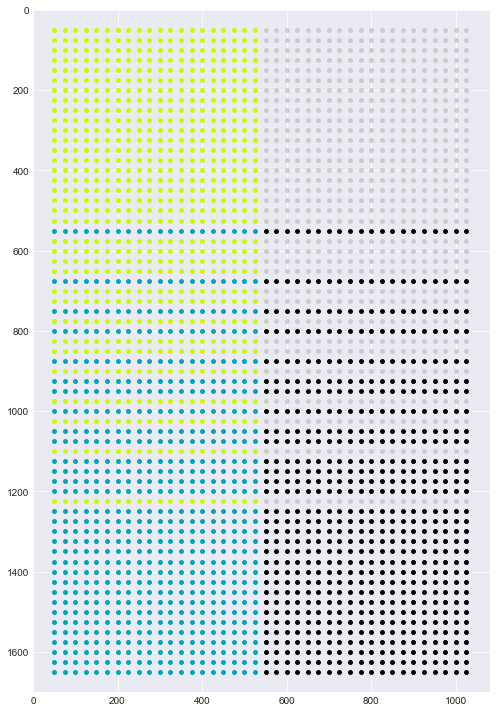

In [49]:
_, _ = cluster_points(YPred, 4)